# $k$-means algorithm

__Table of contents__

1. [Implementation of the algorithm's basic version](#sec1)
2. [Test using MNIST and Iris datasets](#sec2)
3. [Implementation of a version with multiple initializations and finding the best solution](#sec3)
4. [Another initialization strategy: k-means++](#sec4)
5. [Speed up neighbor search](#sec5)

In [ ]:
import time
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.metrics import accuracy_score, pairwise_distances_argmin
from sklearn.model_selection import train_test_split

## <a name="sec1">1. Implementation of the algorithm's basic version </a>

The *k*-means algorithm in pseudo-code:
1. Specify the number *k* clusters to assign.
2. Randomly initialize *k* centroids.
3. __repeat__ 
   > 4. **expectation**: Assign each point to its closest centroid. </br>
   > 5. **maximization**: Compute the new centroid (mean) of each cluster. </br>
   
6. __until__ The centroid positions do not change.   
   
In the following, we denote:
- a cluster's *__label__* as its number, e.g. cluster n°1
- a cluster's *__class__* as the class to which the data points of the cluster belong to, e.g. cluster n°1 can represent the class n°3.


We are going to implement a class `OurKMeans` with two methods:
- `fit()` method which will compute the k-means clustering. Based on the pseudo-code written above, we write a function for each step and combine them in the method. `fit()` will also assign class to clusters. For that, we implement a function `assign_class_to_cluster()` which associate the most probable class to each cluster.
- `predict()` method which will predict the closest cluster each sample of a given x belongs to and retrieve their predicted class. 


In [ ]:
# Functions for each step of the k-means algorithm

def random_initialization(data, k):
    '''Randomly initialize k centroids from data
    
    Args:
        data (array): data points, of shape (n_samples, n_features)
        k (int): number of clusters

    Returns:
        centroids (array): initial centroids of the `k` clusters, of shape (k, n_features)
    '''

    centroids = list(data[np.random.choice(data.shape[0], k, replace=False)])
    return centroids

def assignment(data, centroids):
    '''Assign each point to its closest centroid, i.e to a cluster -> Expectation

    Args:
        data (array): data points, of shape (n_samples, n_features)
        centroids (array): centroids of the `k` clusters, of shape (k, n_features)
    
    Returns:
        clusters_labels (array): clusters' labels which each data point were assign to
                                 of shape (n_samples, )
    '''

    # Compute minimum distances between one point and a set of points. 
    # This function computes for each row in X, the index of the row of Y which is closest (according to the specified distance).
    clusters_labels = pairwise_distances_argmin(data, centroids)
    return clusters_labels

def get_cluster(data, labels, label):
    '''Get the points from the cluster labelled `label`
    
    Args: 
        data (array): data points, of shape (n_samples, n_features)
        labels (array): clusters' labels which each data point were assign to,
                        of shape (n_samples, )
        label (int): the label of the cluster we want to get the data points from

    Returns:
        cluster (list): data points from the cluster of label `label`
    '''

    cluster = [data[i] for i in range(len(data)) if labels[i] == label]
    return cluster

def new_centroid(cluster):
    '''Compute the new centroid of each cluster -> Maximization'''

    centroid = np.average(cluster, axis=0)
    return centroid

def converged(old_centroids, new_centroids):
    '''Compare old_labels to new_labels to know if the centroid positions has changed or not'''

    for i in range(len(old_centroids)):
        if not (old_centroids[i] == new_centroids[i]).all():
            return False
    return True

In [ ]:
def assign_class_to_cluster(cluster_labels, y):
    '''Associate most probable class to each cluster.
    For that, we look among the real classes of the points in the cluster
    and we assign to this cluster the majoritary real class.

    Returns:
        clusters_class (dict): dictionary of {cluster's label : cluster's class}
    '''

    clusters_class = {}
    for i in range(len(np.unique(cluster_labels))):
        index = np.where(cluster_labels == i, 1, 0) # Array filled with 1 if label is i, 0 otherwise
        classes_of_cluster_i = y[index == 1] # Get the class of each data point of the cluster i
        most_probable_class = np.bincount(classes_of_cluster_i).argmax() # Get the most common class of cluster i
        clusters_class[i] = most_probable_class
    return clusters_class

In [ ]:
class OurKMeans:

    def __init__(self, k, max_iter=100):
      '''Initialise an object of the class OurKmeans.

      Args:
        k (int): number of clusters
        max_iter (int): maximum number of iterations (default=100)

      '''
        self.k = k
        self.max_iter = max_iter

    def fit(self, x, y, verbose=False):
        '''Compute k-means clustering and assign class to clusters.

        Args:
            x (array): data points, of shape (n_samples, n_features)
            k (int): number of clusters

        Save:
            labels (list): list of int representing the cluster label of each data point
            centroids (list): list of the k centroids found by the algorithm
            clusters_class (dict):  dictionary of {cluster's label : cluster's class}
        '''

        # 2: Randomly initialize k centroids
        centroids = random_initialization(x, self.k)
        
        old_labels = np.zeros(len(x))

        # 3: Repeat
        for it in range(self.max_iter):
            
            # 4: Assign each point to its closest centroid -> Expectation
            labels = assignment(x, centroids)

            # 5: Compute the new centroid of each cluster -> Maximization
            new_centroids = []
            for i in range(self.k): # for each cluster
                cluster_i = get_cluster(x, labels, i) # we take all the point from this cluster
                centroid_i = new_centroid(cluster_i) # and compute the centroid for this cluster
                new_centroids.append(centroid_i)
            
            # 6: Until the centroid positions do not change
            if converged(centroids, new_centroids):
                if verbose:
                    print(f'k-means has converged in {it} steps.')
                self.centroids = new_centroids
                self.labels = labels
                break

            old_labels = labels
            centroids = new_centroids

        self.centroids = new_centroids
        self.labels = labels
        self.clusters_class = assign_class_to_cluster(self.labels, y)

    def predict(self, x):
        '''Predict the closest centroid each sample in x belongs to
        and retrieve their predicted class.
        '''

        closest_clusters = assignment(x, self.centroids)
        y_pred = np.zeros(x.shape[0])
        for i in range(x.shape[0]):
            y_pred[i] = self.clusters_class[closest_clusters[i]]
        return y_pred

IndentationError: ignored

## <a name="sec2"> 2. Test using MNIST and IRIS test datasets </a>

### 2.1 MNIST dataset

We load the MNIST dataset. 
- `x_mnist` is a numpy array of shape (1797, 64). We have 1797 digits images in total, each of them has 64 features.
- `y_mnist` is a numpy array of the true labels, from 0 to 9. 

In [ ]:
# Load the MNIST dataset
mnist_data = datasets.load_digits()
x_mnist = mnist_data.data # Array (1797, 64)
y_mnist = mnist_data.target # Array (1797,)

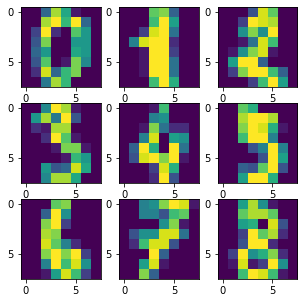

In [ ]:
plt.figure(figsize = (5, 5)) # Adjust figure size

# Display a grid of 3x3 images
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_mnist[i].reshape(8,8))

#### Preprocessing the data

In [ ]:
# Checking the minimum and maximum values of x_mnist
print(x_mnist.min())
print(x_mnist.max())

0.0
16.0


In [ ]:
# Normalizing the data
x_mnist = x_mnist/16.0

In [ ]:
# Checking the minimum and maximum values of x_mnist
print(x_mnist.min())
print(x_mnist.max())

0.0
1.0


The minimum and maximum values are 0 and 1 respectively. The input data is in range of [0,1].

#### Applying $k$-means

In [ ]:
x_train_mnist, x_test_mnist, y_train_mnist, y_test_mnist = train_test_split(x_mnist, y_mnist)
print(f'x_train_mnist {x_train_mnist.shape}, y_train_mnist {y_train_mnist.shape}')
print(f'x_test_mnist {x_test_mnist.shape}, y_test_mnist {y_test_mnist.shape}')

x_train_mnist (1347, 64), y_train_mnist (1347,)
x_test_mnist (450, 64), y_test_mnist (450,)


Next, we apply the *k*-means algorithm to our data. We set the number of clusters `mnist_k` to 10 because there are 10 classes in total.

In [ ]:
mnist_k = 10
mnist_kmeans = OurKMeans(k=mnist_k)
mnist_kmeans.fit(x_train_mnist, y_train_mnist, verbose=True)

k-means has converged in 23 steps.


It took 18 steps to converge. Note that the algorithm is nondeterministic: running the algorithm several times on the same data results in different clusters because of the random initialization. So it could possibly take 13, or 26 steps to converge for example.

In [ ]:
print(mnist_kmeans.labels)
print(mnist_kmeans.labels.shape)

[4 1 2 ... 1 0 8]
(1347,)


Each image of the train set is assigned a cluster label value given by `mnist_kmeans.labels`. So `mnist_kmeans.labels` is an array of length 1347 as there are 1347 images in the train set.

But `mnist_kmeans.labels` only denotes the cluster to which the image belongs to, and doesn't denote the number displayed in image. For example, the first image belongs to cluster 4, but it doesn't mean that the digit displayed is 4. `mnist_kmeans.clusters_class` contains the predicted class of each cluster.

In [ ]:
mnist_kmeans.clusters_class

{0: 2, 1: 7, 2: 1, 3: 3, 4: 0, 5: 4, 6: 1, 7: 5, 8: 8, 9: 6}

The output means that the cluster of label 0 is a cluster of images of 2, a cluster of label 1 is a cluster of images of 7 etc. 
It can be seen that clusters 2 and 6 both denote the cluster of images 1. Occurrences will be solved later in the notebook.

In [ ]:
# Get predicted classes 
y_pred_mnist = mnist_kmeans.predict(x_test_mnist)

In [ ]:
# Compare predicted values and actual values for the first 20 training examples
print(y_pred_mnist[:20].astype('int'))
print(y_test_mnist[:20])

[3 1 7 1 1 5 6 3 0 2 4 0 6 8 3 0 6 2 3 2]
[3 1 7 1 1 5 6 9 0 1 4 0 6 8 5 0 6 2 9 1]


In [ ]:
# Compute accuracy score on test set
print(accuracy_score(y_pred_mnist, y_test_mnist))

0.76



The accuracy score on test set is about 76%.

#### Visualizing the results

We can use PCA to project the data from the original 64-dimensional space into a lower dimensional space, for example 2-dimensional space. Then plot the data and the clusters in this new space.

In [ ]:
def plot_mnist(x, y):
    fig = plt.figure(figsize=(2,1))
    for i in np.unique(y):
        k = np.where(y==i)[0][0]
        plt.subplot(2,5,i+1)
        pixels = x[k,:].reshape((8, 8))
        plt.axis("off")

    plt.show()

    fig = plt.figure(1, figsize=(8, 6))
    X_reduced = PCA(n_components=2).fit_transform(x)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k', s=40)
    plt.colorbar()
    plt.show()

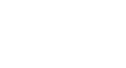

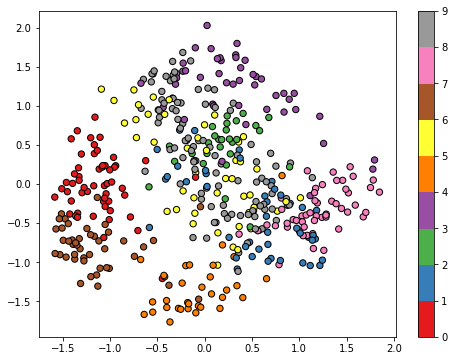

In [ ]:
plot_mnist(x_test_mnist, y_test_mnist) #real classes

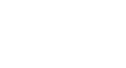

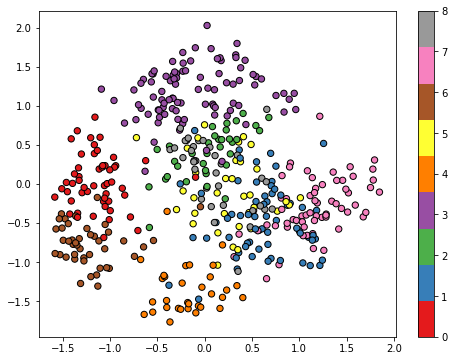

In [ ]:
plot_mnist(x_test_mnist, y_pred_mnist) #predicted classes

### 2.2 IRIS dataset

We load the IRIS dataset. 
- `x_iris` is a numpy array of shape (150, 4). We have 150 examples representing flowers and 4 features (sepal's length, sepal's width, petal's length, petal's width)
- `y_iris` is a numpy array of the true labels, from 0 to 2, representing 3 classes (setosa, versicolor and virginica)

In [ ]:
# Load the IRIS dataset
iris = datasets.load_iris()
x_iris = iris.data # Array (150, 4)
y_iris = iris.target # Array (150,)

In [ ]:
def plot_iris(x, y):
  fig = plt.figure(1, figsize=(8, 6))
  ax = Axes3D(fig, elev=-150, azim=110)

  pca = PCA(n_components=4)
  X_reduced = pca.fit_transform(x)
  V = pca.components_
  meanPoint = x.mean(axis = 0)
  X_centered = x - meanPoint

  ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
            cmap=plt.cm.Set1, edgecolor='k', s=40)
  ax.set_title("First three PCA directions")
  ax.set_xlabel("PCA-1")
  ax.w_xaxis.set_ticklabels([])
  ax.set_ylabel("PCA-2")
  ax.w_yaxis.set_ticklabels([])
  ax.set_zlabel("PCA-3")
  ax.w_zaxis.set_ticklabels([])
  plt.show()

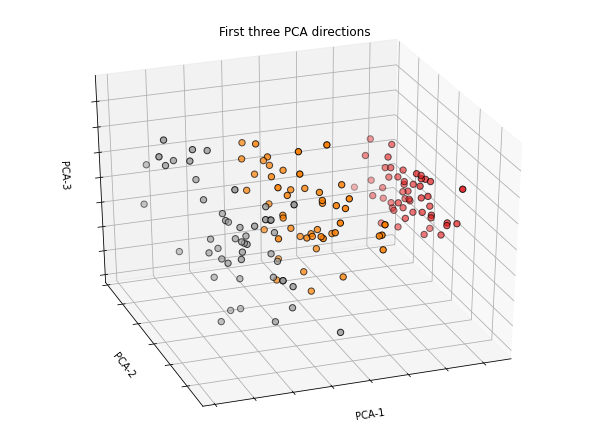

In [ ]:
plot_iris(x_iris, y_iris)

#### Applying $k$-means

In [ ]:
x_train_iris, x_test_iris, y_train_iris, y_test_iris = train_test_split(x_iris, y_iris)
print(f'x_train_iris {x_train_iris.shape}, y_train_iris {y_train_iris.shape}')
print(f'x_test_iris {x_test_iris.shape}, y_test_iris {y_test_iris.shape}')

x_train_iris (112, 4), y_train_iris (112,)
x_test_iris (38, 4), y_test_iris (38,)


Next, we apply the *k*-means algorithm to our data. We set the number of clusters `iris_k` to 3 because there are 3 classes in total.

In [ ]:
iris_k = 3
iris_kmeans = OurKMeans(k=iris_k)
iris_kmeans.fit(x_train_iris, y_train_iris, verbose=True)

k-means has converged in 2 steps.


It took 2 steps to converge for this run. Note that the algorithm is nondeterministic: running the algorithm several times on the same data results in different clusters because of the random initialization.

In [ ]:
print(iris_kmeans.labels)
print(iris_kmeans.labels.shape)

[2 0 2 1 2 0 2 1 0 2 1 0 1 2 1 2 1 1 1 0 0 0 2 2 1 1 1 2 2 1 0 0 1 2 1 2 1
 1 1 2 1 0 2 1 2 2 2 0 0 1 2 0 2 1 2 0 2 0 0 0 0 2 0 1 1 2 2 0 0 2 2 2 1 1
 1 0 1 1 1 2 1 1 2 1 2 2 2 2 0 2 2 1 1 0 1 2 1 1 1 0 0 2 1 1 1 2 1 0 1 1 2
 2]
(112,)


Each example is assigned to a cluster label value given by `iris_cluster_labels`. So `iris_cluster_labels` is an array of length 120 as there are 120 samples in the training dataset.

But `iris_cluster_labels` only denotes the cluster to which the example belongs to, and doesn't denote the true class. Hence, let's see the most probable class for each cluster.

In [ ]:
iris_kmeans.clusters_class

{0: 2, 1: 1, 2: 0}

The output means that the cluster of label 0 is a cluster of flowers of class 2, the cluster of label 1 is a cluster of flowers of class 1, and the cluster of label 2 denotes flowers of class 0.

In [ ]:
# Get predicted classes 
y_pred_iris = iris_kmeans.predict(x_test_iris)

In [ ]:
# Compare predicted values and actual values for the first 20 training examples
print(y_pred_iris[:20].astype('int'))
print(y_test_iris[:20])

[1 2 2 0 2 1 1 0 1 2 2 1 2 0 2 1 1 0 1 1]
[2 2 2 0 2 2 1 0 1 2 2 2 2 0 2 2 1 0 2 1]


In [ ]:
# Compute accuracy score
print(accuracy_score(y_pred_iris, y_test_iris))

0.868421052631579


The accuracy score is about 86%.

#### Visualizing the results

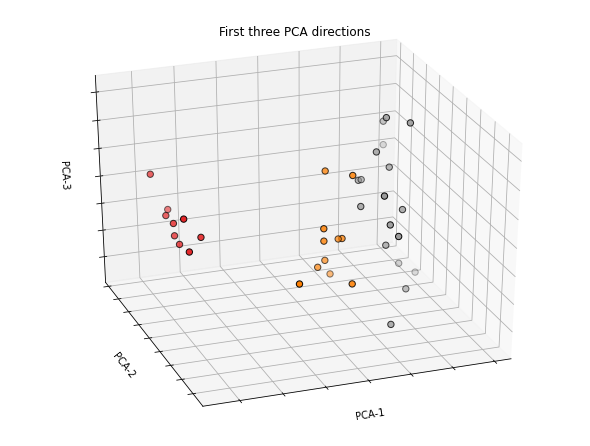

In [ ]:
plot_iris(x_test_iris, y_test_iris)

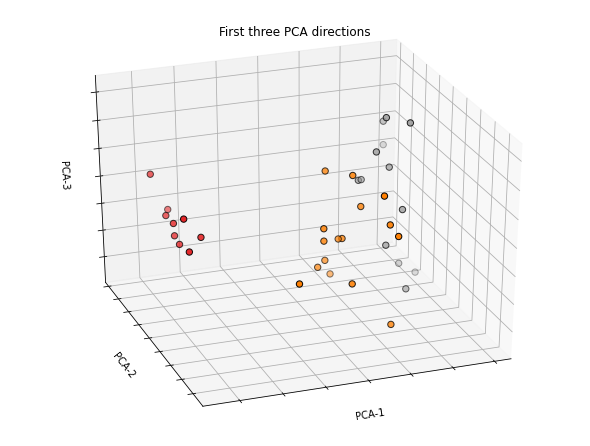

In [ ]:
plot_iris(x_test_iris, y_pred_iris)

From the plot, it can be seen that some samples of class grey originally are assign to the orange class.

## <a name="sec3"> 3. Implement a version with multiple initializations and finding the best solution </a>

We are going to run several initializations of the algorithm and choose the clustering from the initialization with the highest accuracy. There will be two steps:

1. We will use the Elbow method to have an estimation of the optimal number of clusters `k_opt` for the MNIST and IRIS dataset, using sklearn `KMeans` model and [`KElbowVisualizer`](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) from [Yellowbrick API](https://www.scikit-yb.org/en/latest/api/index.html), a Machine Learning Visualizer. 
2. Then, we will run several random initializations (determined by the argument `n_try`) for the `k_opt` to see how sensitive the algorithm is to the initialization of the centroids. 

We choose the model with the initialization which gives the highest accuracy.




In [ ]:
# Imports for step 1
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [ ]:
# Function for step 2
def random_start_kmeans(x_train, y_train, x_test, y_test, k_opt, n_try=10):
    best_labels = np.zeros(len(y_train))
    best_centroids = []
    best_accuracy = 0
    best_model = None
    for i in range(n_try):
        kmeans_model = OurKMeans(k=k_opt)
        kmeans_model.fit(x_train, y_train)
        y_pred = kmeans_model.predict(x_test)
        accuracy = accuracy_score(y_pred, y_test)
        print(f'Iteration {i}: acc = {accuracy}')
        if accuracy > best_accuracy:
            best_model = kmeans_model
            best_labels = kmeans_model.labels
            best_centroids = kmeans_model.centroids
            best_accuracy = accuracy
    print(f'Best accuracy is {best_accuracy}')
    return best_model, best_labels, best_centroids, best_accuracy

### <a name="sec3-1"> 3.1 MNIST dataset </a>


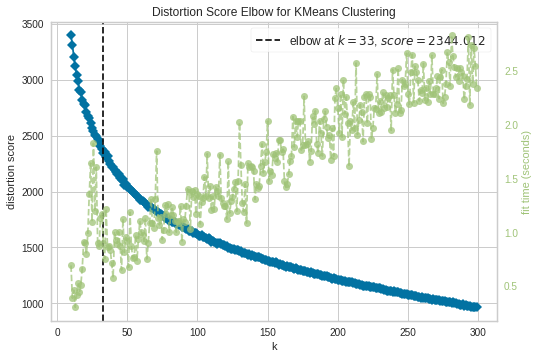

In [ ]:
# Instantiate the clustering model and visualizer
mnist_model = KMeans()
visualizer = KElbowVisualizer(mnist_model, k=(10, 300))

visualizer.fit(x_train_mnist) # Fit the data to the visualizer (14 min)
visualizer.show() # Finalize and render the figure

In [ ]:
k_opt_mnist = 33
best_model_mnist, best_labels_mnist, best_centroids_mnist, best_accuracy_mnist = random_start_kmeans(x_train_mnist, y_train_mnist, x_test_mnist, y_test_mnist, k_opt_mnist)

Iteration 0: acc = 0.9088888888888889
Iteration 1: acc = 0.8955555555555555
Iteration 2: acc = 0.9155555555555556
Iteration 3: acc = 0.8911111111111111
Iteration 4: acc = 0.9311111111111111
Iteration 5: acc = 0.9088888888888889
Iteration 6: acc = 0.9044444444444445
Iteration 7: acc = 0.9022222222222223
Iteration 8: acc = 0.92
Iteration 9: acc = 0.9088888888888889
Best accuracy is 0.9311111111111111


We obtain an accuracy of 93% with k = 33, which far better than 76%.

In [ ]:
# Get predicted classes 
y_pred_mnist = best_model_mnist.predict(x_test_mnist)

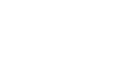

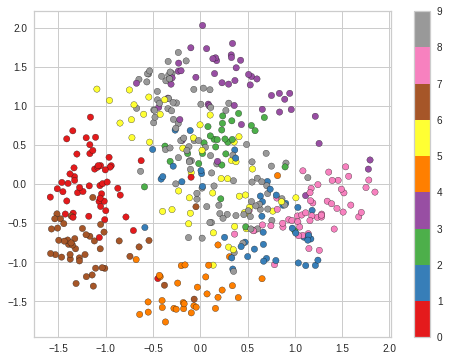

In [ ]:
plot_mnist(x_test_mnist, y_test_mnist)

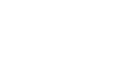

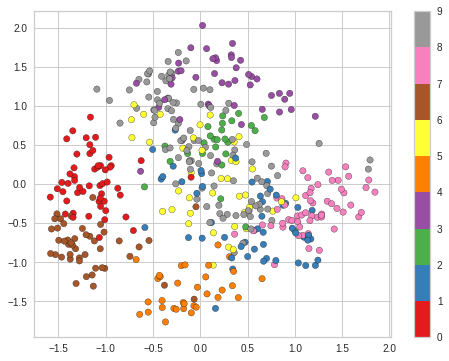

In [ ]:
plot_mnist(x_test_mnist, y_pred_mnist)

### <a name="sec3-2"> 3.2 IRIS dataset </a>


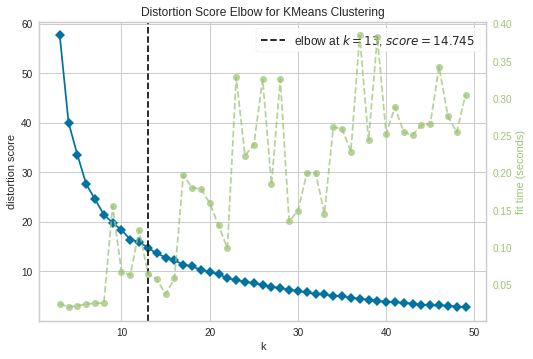

In [ ]:
# Instantiate the clustering model and visualizer
iris_model = KMeans()
visualizer = KElbowVisualizer(iris_model, k=(3, 50)) 

visualizer.fit(x_train_iris) # Fit the data to the visualizer (12 sec)
visualizer.show() # Finalize and render the figure

In [ ]:
k_opt_iris = 13
best_model_iris, best_labels_iris, best_centroids_iris, best_accuracy_iris = random_start_kmeans(x_train_iris, y_train_iris, x_test_iris, y_test_iris, k_opt_iris)

Iteration 0: acc = 0.9473684210526315
Iteration 1: acc = 0.9473684210526315
Iteration 2: acc = 0.9210526315789473
Iteration 3: acc = 0.9473684210526315
Iteration 4: acc = 0.9473684210526315
Iteration 5: acc = 0.9210526315789473
Iteration 6: acc = 0.9736842105263158
Iteration 7: acc = 0.9736842105263158
Iteration 8: acc = 0.9473684210526315
Iteration 9: acc = 0.9736842105263158
Best accuracy is 0.9736842105263158


We obtain an accuracy of 97% on test data (we had 86 before).

In [ ]:
# Get predicted classes 
y_pred_iris = best_model_iris.predict(x_test_iris)

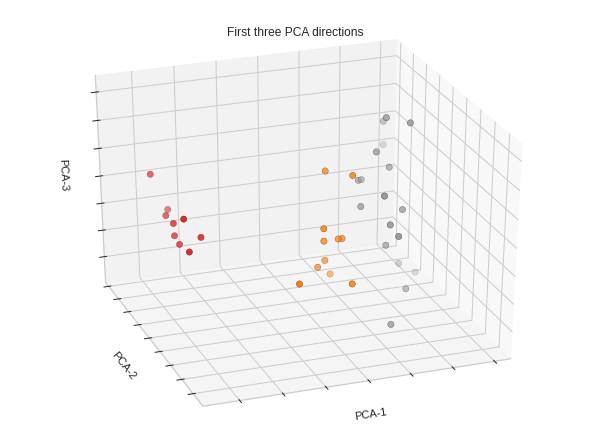

In [ ]:
plot_iris(x_test_iris, y_test_iris)

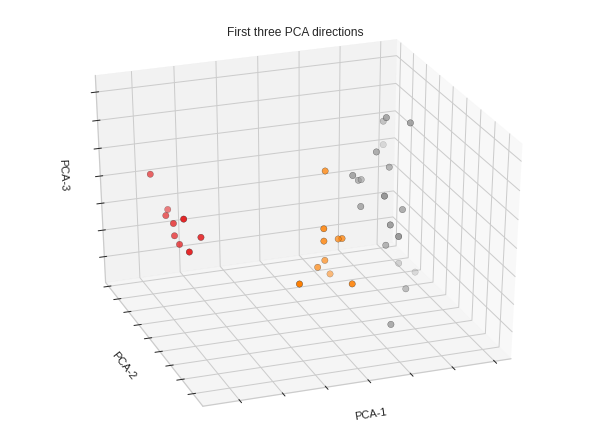

In [ ]:
plot_iris(x_test_iris, y_pred_iris)

## <a name="sec4"> 4. Think of the initialization strategy, compare it with a random one </a>

According to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), *k-means++* is an initialization strategy method that "selects initial cluster centers for k-mean clustering in a smart way to speed up convergence". 

The idea is to initialize centroids that are far away from one another, so that the centroids are likely to lie in different clusters in the beginning of the algorithm. For that, firstly we randomly select a data point as the first centroid. Then for each data point, we compute the distance from the nearest previously chosen centroid, and select the data point which maximizes the distance to the nearest previously chosen centroid. Repeat this step until *k* centroids have been sampled.

We will implement this strategy and compare it with the random one on some blobs data in two ways: accuracy and convergence time to optimum.

kmeans++ algorithm (from the [original paper](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf)): https://www.geeksforgeeks.org/ml-k-means-algorithm/


In [ ]:
# function to compute euclidean distance
def distance(p1, p2):
	return np.sum((p1 - p2)**2)

# initialization algorithm
def kmeans_pp_initialization(data, k):
	'''
	initialized the centroids for K-means++
	inputs:
		data - numpy array of data points having shape (200, 2)
		k - number of clusters
	'''
	## initialize the centroids list and add
	## a randomly selected data point to the list
	centroids = random_initialization(data, k=1)

	## compute remaining k - 1 centroids
	for c_id in range(k - 1):
		
		## initialize a list to store distances of data
		## points from nearest centroid
		dist = []
		for i in range(data.shape[0]):
			point = data[i, :]
			d = sys.maxsize
			
			## compute distance of 'point' from each of the previously
			## selected centroid and store the minimum distance
			for j in range(len(centroids)):
				temp_dist = distance(point, centroids[j])
				d = min(d, temp_dist)
			dist.append(d)
			
		## select data point with maximum distance as our next centroid
		dist = np.array(dist)
		next_centroid = data[np.argmax(dist), :]
		centroids.append(next_centroid)
		dist = []
	return centroids

In [ ]:
class OurKMeans:

    def __init__(self, k, init='random', max_iter=100):
        self.k = k
        self.init = init
        self.max_iter = max_iter

    def fit(self, x, y, verbose=False):
        '''Compute k-means clustering and assign class to clusters.

        Args:
            x (array): data points, of shape (n_samples, n_features)
            k (int): number of clusters

        Save:
            labels (list): list of int representing the cluster label of each data point
            centroids (list): list of the k centroids found by the algorithm
            clusters_class (dict):  dictionary of {cluster's label : cluster's class}
        '''

        # 2: Randomly initialize k centroids
        if self.init == 'random':
            centroids = random_initialization(x, self.k)
        elif self.init == 'kmeans++': # For question 4
            centroids = kmeans_pp_initialization(x, self.k)
            
        old_labels = np.zeros(len(x))

        # 3: Repeat
        for it in range(self.max_iter):
            
            # 4: Assign each point to its closest centroid -> Expectation
            labels = assignment(x, centroids)

            # 5: Compute the new centroid of each cluster -> Maximization
            new_centroids = []
            for i in range(self.k): # for each cluster
                cluster_i = get_cluster(x, labels, i) # we take all the point from this cluster
                centroid_i = new_centroid(cluster_i) # and compute the centroid for this cluster
                new_centroids.append(centroid_i)
            
            # 6: Until the centroid positions do not change
            if converged(centroids, new_centroids):
                if verbose:
                    print(f'k-means has converged in {it} steps.')
                self.centroids = new_centroids
                self.labels = labels
                break

            old_labels = labels
            centroids = new_centroids

        self.centroids = new_centroids
        self.labels = labels
        self.clusters_class = assign_class_to_cluster(self.labels, y)

    def predict(self, x):
        '''Predict the closest cluster each sample in x belongs to
        and retrieve their predicted class.
        '''

        closest_clusters = assignment(x, self.centroids)
        y_pred = np.zeros(x.shape[0])
        for i in range(x.shape[0]):
            y_pred[i] = self.clusters_class[closest_clusters[i]]
        return y_pred

In [ ]:
from sklearn.datasets import make_blobs

centers = 3
x_blobs, y_blobs = make_blobs(n_samples=1000, n_features=12, centers=centers, random_state=42)

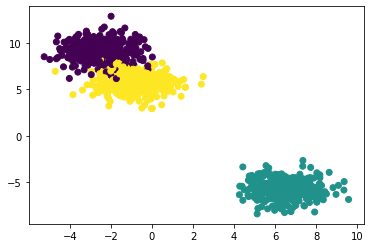

In [ ]:
# Plot first and second dimension
plt.scatter(x_blobs[:, 0], x_blobs[:, 1], c=y_blobs)

In [ ]:
x_train_blobs, x_test_blobs, y_train_blobs, y_test_blobs = train_test_split(x_blobs, y_blobs)

In [ ]:
blobs_rand_kmeans = OurKMeans(k=4, init='random')
blobs_rand_kmeans.fit(x_train_blobs, y_train_blobs, verbose=True)

k-means has converged in 32 steps.


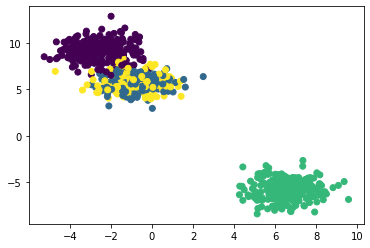

In [ ]:
plt.scatter(x_train_blobs[:, 0], x_train_blobs[:, 1], c=blobs_rand_kmeans.labels)

In [ ]:
# Get predicted classes and compute accuracy for random initialization
y_pred_blobs_rand = blobs_rand_kmeans.predict(x_test_blobs)
print(accuracy_score(y_pred_blobs_rand, y_test_blobs))

1.0


In [ ]:
blobs_kmeans_pp = OurKMeans(k=centers, init='kmeans++')
blobs_kmeans_pp.fit(x_train_blobs, y_train_blobs, verbose=True)

k-means has converged in 1 steps.


In [ ]:
# Get predicted classes and compute accuracy for kmeans++
y_pred_blobs_kmeans_pp = blobs_kmeans_pp.predict(x_test_blobs)
print(accuracy_score(y_pred_blobs_kmeans_pp, y_test_blobs))

1.0


Although the initialization is computationally more expensive for k-means++, the convergence is drastically reduced with k-means++ compared to the standard k-means. This is because the centroids are initially chosen to lie in different clusters from the beginning.

We also obtain a perfect accuracy on this dataset with k-means++.

## <a name="sec5"> 5. Try to speed up the neighbor search, demonstrate when it can be advantageous </a>

Let's focus on the assignment step which consists in assigning each data point to its closest centroid. It demands $n\_samples \times k$ distance computations. [Fausett and Celebi](https://www.aaai.org/ocs/index.php/FLAIRS/FLAIRS13/paper/viewFile/5902/6112) proposed to accelerate the neighbor search based on a rejection test of whether given a data point $x$, its nearest centroid $c_i$ and a new potential centroid $c_j$, $c_j$ lies outside or inside the circle centered at $x$ with a radius equal to the distance between $x$ and $c_i$. This computation doesn't require the full computation (euclidean distance for each dimension) of the distance between $x$ and $c_j$, only a few computations can be sufficient to reject the new centroid or not.


```
def assignment(data, centroids):
    '''Assign each point to its closest centroid, i.e to a cluster -> Expectation

    Args:
        data (array): data points, of shape (n_samples, n_features)
        centroids (array): centroids of the `k` clusters, of shape (k, n_features)
    
    Returns:
        clusters_labels (array): clusters' labels which each data point were assign to
                                 of shape (n_samples, )
    '''

    # Compute minimum distances between one point and a set of points. 
    # This function computes for each row in X, the index of the row of Y which is closest (according to the specified distance).
    clusters_labels = pairwise_distances_argmin(data, centroids)
    return clusters_labels
```

In [ ]:
def rejection_test(x, centroid, dist_min):
    radius = np.sqrt(dist_min)
    T = 0
    D = x.shape[0]
    V = np.zeros(D)
    for d in range(D):
        V[d] = np.abs(x[d] - centroid[d])
        if V[d] >= radius:
            return True
        T += V[d]
    if T >= radius*np.sqrt(D):
        return True
    return False

def assignment_accelerated(data, centroids):
    clusters_labels = []
    D = data.shape[1]
    for x in data:
        dist_min = distance(x, centroids[0]) # Distance between data point x and the first centroid
        closest_cluster_label = 0
        for j in range(1, len(centroids)):
            if rejection_test(x, centroids[j], dist_min) == False:
                dist_min = distance(x, centroids[j])
                closest_cluster_label = j
        clusters_labels.append(closest_cluster_label)
    return np.array(clusters_labels)

In [ ]:
centroids = random_initialization(x_blobs, 10)
print(assignment(x_blobs[:10], centroids))
print(assignment_accelerated(x_blobs[:10], centroids))

[5 2 3 4 2 9 1 9 8 9]
[8 7 3 4 2 9 9 9 8 9]


The accelerated assignment does not give the same result as the standard assignement. Our implementation of the paper is perhaps wrong but we couldn't not find the error.

In [ ]:
for i in range(10):
    print(f'{i}: {distance(x_blobs[0], centroids[i])}')

0: 949.0380729860249
1: 1048.0487060664914
2: 892.5191351702275
3: 1165.5685242545615
4: 852.4236949752744
5: 723.5181703221625
6: 756.2309503445979
7: 923.3449810784557
8: 904.4827243030444
9: 1483.175442002968


Above, we display the distance of the first data point to each centroid. The closest one is the centroid 5, but the accelerated version assigned it to the centroid 8 (904 > 723).